**Plotting RH vs Cloud Cover**

In [1]:
# Ran with Python 3 environment
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import sympy as sp

sys.path.insert(0, os.environ['HOME'] + '/workspace_icon-ml/cloud_cover_parameterization')

import tensorflow as tf
import my_classes
import time
import json

from my_classes import read_mean_and_std
from tensorflow.keras.models import load_model
from tensorflow import nn

abspath = os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/evaluate_schemes/analyzing_eqns/v1/'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

matplotlib.use('PDF')

In [2]:
# Load data
output_path = os.environ['HOME'] + '/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND'

input_data = np.load(output_path + '/cloud_cover_input_dyamond.npy')
output_data = np.load(output_path + '/cloud_area_output_dyamond.npy')

# To locate variables
features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
                  'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']
len(features)

loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [3]:
# Run with random subset (the entire dataset takes too much memory)
np.random.seed(10)
rand_int = np.random.randint(0, input_data.shape[0], 10**8)

input_data = input_data[rand_int]
output_data = output_data[rand_int]

In [4]:
# Scale data
mean,std = read_mean_and_std(os.environ['HOME'] + '/workspace_icon-ml/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/saved_models/cross_validation_neighborhood_based_sr_cl_area_fold_2.txt')

input_data_scaled = (input_data - mean)/std

all_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z', 'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_features)):
    loc_all[all_features[i]] = i

In [5]:
# Best PySR equations
with open(os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/optimized_eqns.json', 'r') as file:
    pysr_eqns = json.load(file)
    
rh, ta, rh_z, cli, clw = sp.symbols('rh ta rh_z cli clw')
x0, x1, x2, x3, x4 = sp.symbols('x0 x1 x2 x3 x4')
    
pysr_EQ1 = sp.lambdify((rh, ta, rh_z, cli, clw), pysr_eqns['EQ1']['Equation w.r.t. physical vars'])
pysr_EQ4 = sp.lambdify((rh, ta, rh_z, cli, clw), pysr_eqns['EQ4']['Equation w.r.t. physical vars'])

def pysr_EQ1_mod(rh, ta, rh_z, cli, clw):
    # Artificially increase RH to ensure RH-constraint
    (a,b,c,d) = (38.85954116, 42.70818472, 19.34746465, 1.11321032)
    
    x0 = (rh - mean[loc_all['rh']])/std[loc_all['rh']]
    x1 = (ta - mean[loc_all['ta']])/std[loc_all['ta']]
    
    x0 = np.maximum(x0, 1/(2*c*d)*(-c*x1**2-a))
    
    rh = x0*std[loc_all['rh']] + mean[loc_all['rh']]
    
    return pysr_EQ1(rh, ta, rh_z, cli, clw)    
    
def pysr_EQ4_mod(rh, ta, rh_z, cli, clw):
    # Artificially increase RH to ensure RH-constraint
    (a,b,c,d) = (38.6562122, 43.53500518, 19.78403208, 1.13637902)
    
    x0 = (rh - mean[loc_all['rh']])/std[loc_all['rh']]
    x1 = (ta - mean[loc_all['ta']])/std[loc_all['ta']]
    
    x0 = np.maximum(x0, 1/(2*c*d)*(-c*x1**2-a))
    
    rh = x0*std[loc_all['rh']] + mean[loc_all['rh']]
    
    return pysr_EQ4(rh, ta, rh_z, cli, clw)  

In [6]:
# Load NN
custom_objects = {}
custom_objects['leaky_relu'] = nn.leaky_relu

# SFS 24 (from workspace/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/saved_models/cross_validation_neighborhood_based_sr_cl_area_fold_2.h5)
sfs_24_nn = load_model(os.environ['HOME'] + '/workspace_icon-ml/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/saved_models/cross_validation_neighborhood_based_sr_cl_area_fold_2.h5', custom_objects)

def b(x):
    return np.minimum(np.maximum(x, 0), 100)

2023-04-03 13:47:37.744892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-03 13:47:37.744928: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-03 13:47:37.744952: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l40262.lvt.dkrz.de): /proc/driver/nvidia/version does not exist
2023-04-03 13:47:37.745282: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Add data PDPs to the plots!
# Runs for 70s*len(X_vals)
def find_closest_samples(X, X_vals, N):
    '''
        X [str]: The feature, for which we should not use the mean
        X_vals [list(float)]: The values for the scaled! features (instead of the mean)
        N [int]: The number of closest samples, that shall be in the output
        returns: The indices of the N closest samples
    '''
    indices = np.zeros((input_data_scaled.shape[0], len(X_vals)))
    
    feats = ['rh', 'ta', 'rh_z', 'cli', 'clw']
    feats.remove(X)
    feat_inds = [loc[feat] for feat in feats]
    s = np.sum(np.abs(input_data_scaled[:, feat_inds]), axis=1)
    
    for k in range(len(X_vals)):
        indices[:, k] = s + np.abs(input_data_scaled[:, loc[X]] - X_vals[k])
        
    sorted_inds = np.argsort(indices, axis=0) # Takes most of the time
    return sorted_inds[:N]

In [8]:
ta_mean = np.mean(input_data[:, loc['ta']])
rh_z_mean = np.mean(input_data[:, loc['rh_z']])
cli_mean = np.mean(input_data[:, loc['cli']])
clw_mean = np.mean(input_data[:, loc['clw']])
rh_mean = np.mean(input_data[:, loc['rh']])

ta_std = np.mean(input_data[:, loc['ta']])
rh_z_std = np.mean(input_data[:, loc['rh_z']])
cli_std = np.mean(input_data[:, loc['cli']])
clw_std = np.mean(input_data[:, loc['clw']])
rh_std = np.mean(input_data[:, loc['rh']])

**Relative Humidity**

In [14]:
matplotlib.rcParams['legend.fontsize'] = 12.6
matplotlib.rcParams['axes.labelsize'] = 12.6
matplotlib.rcParams['axes.titlesize'] = 15.2
matplotlib.rcParams['xtick.labelsize'] = 12.6
matplotlib.rcParams['ytick.labelsize'] = 12.6

1373.125249862671

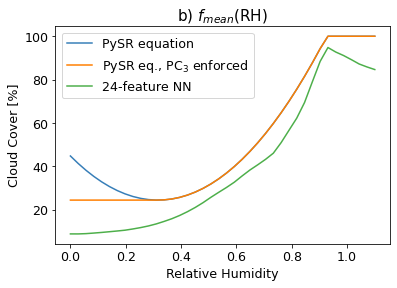

In [16]:
t0 = time.time()

# Runs for 80 mins, with all data! For 17 minutes with 10**8 samples.
rh_vals = np.linspace(np.min(input_data[:, loc['rh']]), 1.1, 40)

# sample_indices = find_closest_samples('rh', (rh_vals - rh_mean)/rh_std, 100) # The Bottleneck! Scales with O(len(rh_vals)).
# output_mean_data = [np.mean(output_data[sample_indices[:, k]]) for k in range(len(rh_vals))]

output_sfs_nn_24 = []
for rh in rh_vals:
    input_arr = np.expand_dims((np.mean(input_data, axis=0) - mean)/std, 0)
    input_arr[0, loc['rh']] = (rh - mean[loc['rh']])/std[loc['rh']]
    pred = b(sfs_24_nn.predict(input_arr))
    output_sfs_nn_24.append(pred)

# To be able to save the numbers
plot_values = {}
plot_values['RH values'] = list(rh_vals)
for eq_num in ['1', '1_mod', '4', '4_mod']:
    plot_values['pysr_EQ%s'%eq_num] = list(b(locals()['pysr_EQ%s'%eq_num](rh_vals, ta_mean, rh_z_mean, cli_mean, clw_mean)))
plot_values['sfs_nn_24'] = list(np.float64(np.array(output_sfs_nn_24)[:,0,0]))
# plot_values['data_mean'] = list(np.float64(output_mean_data))
    
# plt.plot(rh_vals, plot_values['pysr_EQ1'], color=CB_color_cycle[0])
# plt.plot(rh_vals, plot_values['pysr_EQ1_mod'], color=CB_color_cycle[1])
plt.plot(rh_vals, plot_values['pysr_EQ4'], color=CB_color_cycle[0])
plt.plot(rh_vals, plot_values['pysr_EQ4_mod'], color=CB_color_cycle[1])
plt.plot(rh_vals, plot_values['sfs_nn_24'], color=CB_color_cycle[2])
# plt.plot(rh_vals, plot_values['data_mean'], color='black')
plt.title('b) $f_{mean}$(RH)')
# plt.legend(['PySR equation', 'PySR eq., PC$_3$ enforced', 'SFS NN 24', 'DYAMOND cl_area'])
plt.legend(['PySR equation', 'PySR eq., PC$_3$ enforced', '24-feature NN'])
plt.xlabel('Relative Humidity')
plt.ylabel('Cloud Cover [%]')
plt.savefig('RH_vs_cl_area_mod.pdf')

# # Restore default figsize
# plt.close()
# plt.clf()
# plt.figure()

time.time() - t0